In [4]:
import scipy,io
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, SimpleRNN, Input, TimeDistributed, GRU, LSTM
from tensorflow.keras.optimizers import AdamW, RMSprop, Nadam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.initializers import he_normal
from tensorflow.keras.regularizers import L1, L2
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, PolynomialFeatures, StandardScaler, normalize, MinMaxScaler
from sklearn.decomposition import PCA
import math
import matplotlib.pyplot as plt
from scikeras.wrappers import KerasClassifier, KerasRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_classification

mat = scipy.io.loadmat('../UNT-Thermography-24/GaN_data/data_GaN_8_15micron_1.mat')
mat2 = scipy.io.loadmat('../UNT-Thermography-24/GaN_data/data_GaN_8_15micron_2.mat')
mat3 = scipy.io.loadmat('../UNT-Thermography-24/GaN_data/data_GaN_8_15micron_3.mat')


temp_comb = np.concatenate((mat.get('T_GaN_random'), mat2.get('T_GaN_random'), mat3.get('T_GaN_random')), axis=2)
spectra_comb = np.concatenate((mat.get('Spectrum'), mat2.get('Spectrum'), mat3.get('Spectrum')), axis=2)


X_scaler, y_scaler = MinMaxScaler(), MinMaxScaler()

samples = spectra_comb.shape[2]

reshaped_spectra = spectra_comb.reshape(-1, samples).T
reshaped_temp = temp_comb.reshape(-1, samples).T

X_train, X_test, y_train, y_test = train_test_split(reshaped_spectra, reshaped_temp, train_size=0.9, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, train_size=0.8, random_state=42)

X_train = X_train.T.reshape(spectra_comb.shape[0], spectra_comb.shape[1], -1)
X_val = X_val.T.reshape(spectra_comb.shape[0], spectra_comb.shape[1], -1)
X_test = X_test.T.reshape(spectra_comb.shape[0], spectra_comb.shape[1], -1)

y_train = y_train.T.reshape(temp_comb.shape[0], temp_comb.shape[1], -1)
y_val = y_val.T.reshape(temp_comb.shape[0], temp_comb.shape[1], -1)
y_test = y_test.T.reshape(temp_comb.shape[0], temp_comb.shape[1], -1)

X_train = X_train.transpose(2, 0, 1)
X_val = X_val.transpose(2, 0, 1)
X_test = X_test.transpose(2, 0, 1)

y_train = y_train.transpose(2, 0, 1)
y_val = y_val.transpose(2, 0, 1)
y_test = y_test.transpose(2, 0, 1)


In [5]:
y_train.shape


(7200, 5, 10)

In [6]:
model = Sequential()
model.add(Input(shape=(5, 71)))
model.add(LSTM(256, activation='relu', return_sequences=True))
model.add(LSTM(128, activation='relu', return_sequences=True))
model.add(LSTM(64, activation='relu', return_sequences=True))
model.add(LSTM(32, activation='relu', return_sequences=True))
model.add(LSTM(16, activation='relu', return_sequences=True))
model.add(TimeDistributed(Dense(10, activation='linear')))

model.summary()

nadam = Nadam(learning_rate=0.001)

model.compile(optimizer=nadam, loss='mse', metrics=['accuracy'])

model.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val))


test_loss = model.evaluate(X_test, y_test)
print(f'Test loss: {test_loss}')

y_pred = model.predict(X_test)
print(f'Prediction shape: {y_pred.shape}')

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 5, 256)         │       335,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 5, 128)         │       197,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 5, 64)          │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 5, 32)          │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 5, 16)          │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 5, 10)          │           170 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 598,122 (2.28 MB)

 Trainable params: 598,122 (2.28 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.4769 - loss: 81650.7344 - val_accuracy: 0.1620 - val_loss: 15600.8467
Epoch 2/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.1847 - loss: 7594.0586 - val_accuracy: 0.0217 - val_loss: 76.5214
Epoch 3/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.0641 - loss: 68.9536 - val_accuracy: 0.2212 - val_loss: 56.0686
Epoch 4/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.2239 - loss: 55.1617 - val_accuracy: 0.2216 - val_loss: 52.0395
Epoch 5/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.2520 - loss: 52.5910 - val_accuracy: 0.2216 - val_loss: 51.3849
Epoch 6/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.2539 - loss: 52.5143 - val_accuracy: 0.2577 - val_loss: 51.2655
Epoch 7/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.2540 - loss: 52.1730 - val_accuracy: 0.2216 - val_loss: 51.2830
Epoch 8/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.

In [10]:
temp_diff = y_test - y_pred
print(temp_diff)

[[[-4.98586034e+00 -1.85884900e+01  7.24430505e+00 ...  5.45074147e+00
    1.04653788e+01  3.31076455e+01]
  [ 2.22172028e+00  2.49501025e+00  1.09081956e+00 ...  7.98496461e-01
    7.93411591e-01  7.92932698e-01]
  [ 2.72413594e+00  2.70718468e+00  2.07436494e+00 ... -6.10426479e-01
   -7.58979161e-01 -8.50478085e-02]
  [ 1.79649296e+00  1.50432275e+00  1.23188488e+00 ... -9.41500118e-02
   -5.50753308e-03  5.59695054e-01]
  [-1.63902680e-01 -6.13968552e-01 -4.61951635e-01 ...  7.68780450e-01
    1.05441586e+00  1.35620840e+00]]

 [[ 1.68547377e+01 -5.66805252e+00 -7.56710602e+00 ...  7.32901381e+00
    2.03459293e+01  1.52512930e+01]
  [ 3.25845843e-01  8.93828888e-01  3.13364120e-01 ...  1.87398791e+00
    1.44215325e+00  1.07539994e+00]
  [ 2.07168049e+00  2.14505889e+00  1.75480573e+00 ...  3.62060832e-02
   -2.60756991e-01  1.83979447e-01]
  [ 1.53588796e+00  1.28476531e+00  1.11242759e+00 ...  2.37156505e-01
    2.58385231e-01  7.05517907e-01]
  [-2.64878286e-01 -6.93643088e-01 

In [11]:
max = np.max(np.abs(temp_diff))
min = np.min(np.abs(temp_diff))

In [13]:
max

50.61365198151708

In [14]:
min

2.787698315387388e-05

In [15]:
# Select a random index for a 5x10 segment
random_index = np.random.randint(0, len(y_test))
actual_segment = y_test[random_index]
predicted_segment = y_pred[random_index]

In [16]:
temp_T = temp_comb.transpose(2, 0, 1)

In [17]:
transposed = temp_T[0]

In [18]:
original = temp_comb[:, :, 0]

In [19]:
transposed - original

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

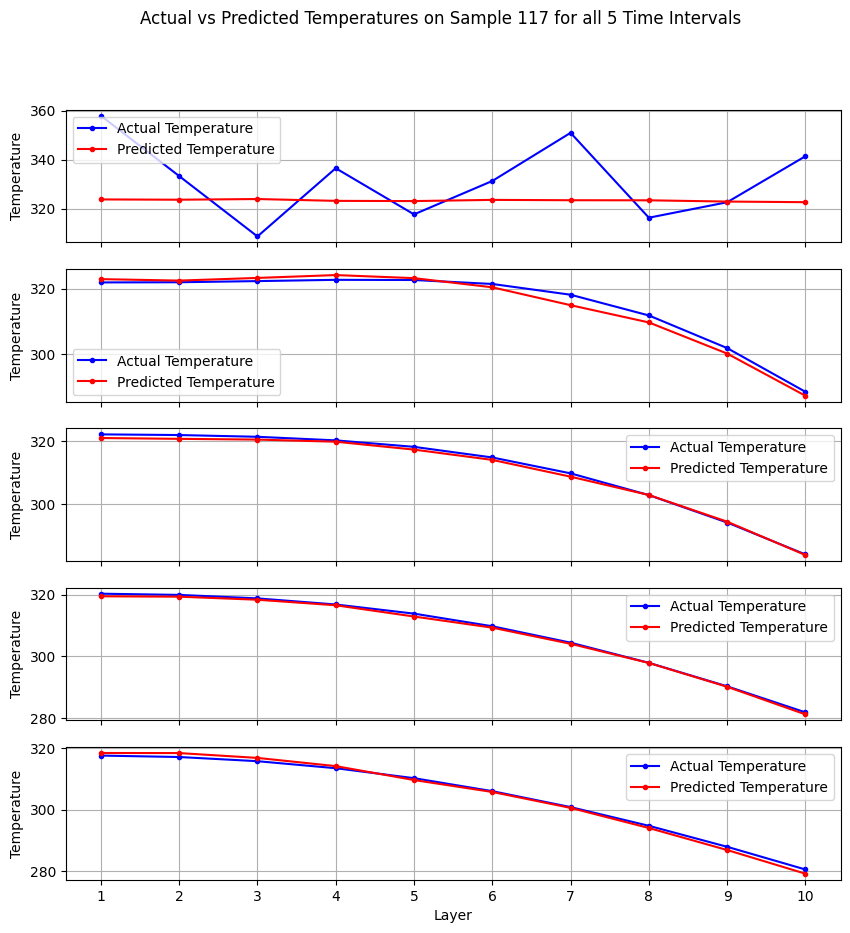

In [21]:
# Select a random index for a 5x10 segment
random_index = np.random.randint(0, len(y_test))
actual_segment = y_test[random_index]
predicted_segment = y_pred[random_index]

x = range(1, 11)

# Plot the selected segments
fig, axs = plt.subplots(5, 1, figsize=(10, 10), sharex=True)
for i in range(5):
    axs[i].plot(x, actual_segment[i], 'b.-', label='Actual Temperature')
    axs[i].plot(x, predicted_segment[i], 'r.-', label='Predicted Temperature')
    plt.xlabel('Layer')
    plt.xticks(np.arange(1, 11, step=1))
    axs[i].set_ylabel('Temperature')
    axs[i].legend()
    axs[i].grid(True)

plt.xlabel('Layer')
plt.suptitle(f"Actual vs Predicted Temperatures on Sample {random_index} for all 5 Time Intervals")
plt.show()